`ECML-PKDD 2024 Tutorial / An introduction to Time Series Machine Learning`

# Anomaly Detection with `aeon`

Time Series Anomaly Detection aims at discovering regions of a time series that in some
way are not representative of the underlying generative process. There is no universally
agreed upon definition for an anomaly, and different domains and algorithms have
different definitions for anomalies. In the context of this tutorial and within `aeon`,
we refer to any rare point or sequence of points that deviates from the normal behavior
of the time series as an anomaly.

The detectors have different capabilities that can be grouped into the following
categories, where `m` is the number of time points and `d` is the number of channels for
a time series:

Input data format (one of the following):

- **Univariate** series (default):
  The input time series contains only a single channel/variate.

  - `np.ndarray`, shape `(m,)`, `(m, 1)` or `(1, m)` depending on axis.
  - `pd.DataFrame`, shape `(m, 1)` or `(1, m)` depending on axis.
  - `pd.Series`, shape `(m,)`.

- **Multivariate** series:
  The input time series consists of multiple related channels.
  All channels need to be measured using the same resolution (same equidistant intervals).

  - `np.ndarray` array, shape `(m, d)` or `(d, m)` depending on axis.
  - `pd.DataFrame`, shape `(m, d)` or `(d, m)` depending on axis.

Output data format (one of the following):

- Anomaly **scores** (default):
  `np.ndarray`, shape `(m,)` of type `float`. For each point of the input time series,
  the anomaly score is a float value indicating the degree of anomalousness. The higher
  the score, the more anomalous the point. The detectors return raw anomaly scores that
  are not normalized.

- **Binary** classification:
  `np.ndarray`, shape `(m,)` of type `bool` or `int`. For each point of the input time
  series, the output is a boolean or integer value indicating whether the point is
  anomalous (`True`/`1`) or not (`False`/`0`).

Detector learning types:

- **Unsupervised** (default):
  Unsupervised detectors do not require any training data and can directly be used on the
  target time series. You would usually call the `fit_predict` method on these detectors.

- **Semi-supervised**:
  Semi-supervised detectors require a training step on a time series without anomalies
  (normal behaving time series). The target value `y` would consist of only zeros. You
  would typically first call the `fit` method on the training time series and then the
  `predict` method on your target time series.

- **Supervised**:
  Supervised detectors require a training step on a time series with known anomalies
  (anomalies should be present and must be annotated). The detector implements the `fit`
  method, and the target value `y` consists of zeros and ones; ones indicating points of
  an anomaly. You would typically first call the `fit` method on the training data and,
  then, the `predict` method on your target time series.

We start by installing the latest aeon-release and some soft-dependencies for the
anomaly detectors, downloading example datasets, and defining some utility functions
(i.a. for plotting).

In [ ]:
!pip install aeon==0.11.0 matplotlib seaborn pyod stumpy prts
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/nyc_taxi.csv -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/S1-ADL1.csv -P data/

In [1]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

sns.set()
sns.set_context("talk")

def mask_to_slices(mask):
    tmp = np.r_[0, mask, 0]
    slices = np.c_[
        np.nonzero(np.diff(tmp) == 1)[0],
        np.nonzero(np.diff(tmp) == -1)[0]
    ]
    return slices

def plot_anomaly_detection(X, y=None, scores=None, title=""):
    X = np.asarray(X)
    fig, axs = plt.subplots(
        1 if scores is None else 1 + len(scores),
        1,
        sharex=True,
        gridspec_kw={"hspace": 0.05},
        figsize=(20, 5 if scores is None else 5 + 2*len(scores)),
        squeeze=False
    )
    fig.suptitle(title)
    axs = axs.flatten()
    if X.ndim == 1:
        axs[0].plot(X, color="black", lw=2, label="time series")
    elif X.ndim == 2:
        for i in range(X.shape[1]):
            if i >= 8:
                print(f"Too many ({X.shape[1]}) channels, just plotting 8!")
                break
            axs[0].plot(X[:, i], lw=2, label=f"channel-{i}")
    if y is not None:
        y = np.asarray(y)
        anomalies = mask_to_slices(y)
        y0, y1 = axs[0].get_ylim()
        height = y1 - y0
        for b, e in anomalies:
            axs[0].add_patch(
                Rectangle((b, y0), e-b, height,
                          edgecolor="orange",
                          facecolor="yellow",
                          alpha=0.5)
            )

    if scores is not None and len(scores) > 0:
        for i, est in enumerate(scores):
            axs[i+1].plot(scores[est], color="orange", lw=2, label=est)
            axs[i+1].set_ylabel(est)
    return fig, axs

## Example Datasets

First, we load some example anomaly detection problems:

The [KDD or HEX benchmark dataset collection](https://compete.hexagon-ml.com/practice/competition/39/) proposed for a SIGKDD competition consists of 250 univariate time series with a single annotated anomaly (discord). We load time series number 135 measuring internal bleeding that is packaged within aeon:

(<Figure size 2000x500 with 1 Axes>, array([<Axes: >], dtype=object))

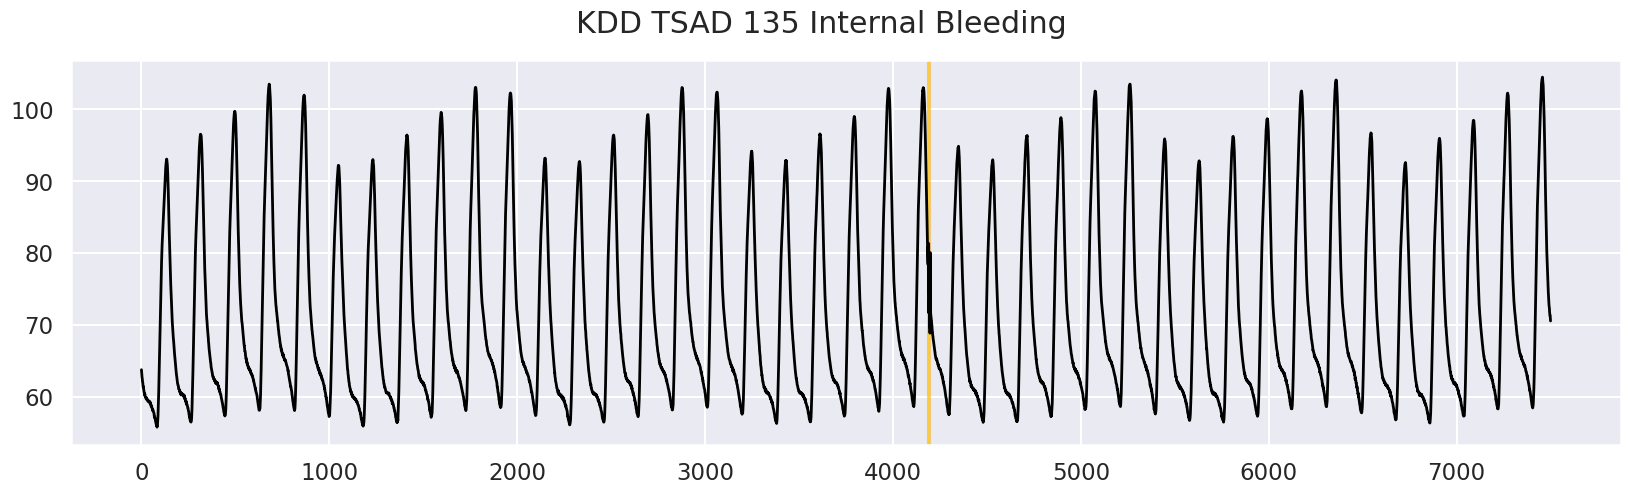

In [3]:
import pandas as pd
from aeon.datasets import load_anomaly_detection, load_kdd_tsad_135
from aeon.visualisation import plot_series_with_profiles

# this dataset consists of a training time series with no anomalies and the test time series:
X, y = load_kdd_tsad_135()
X_train, y_train = load_kdd_tsad_135(split="train")
np.testing.assert_array_equal(y_train, 0)

plot_anomaly_detection(X, y, title="KDD TSAD 135 Internal Bleeding")

Another famous demo time series is the New York Taxi dataset. It is also univariate but contains multiple annotated anomalies and one can find additional unlabeled anomalous subsequences that relate to real-world anomalies. To demonstrate multivariate capabilities, we use a dataset with 133 sensor measurements from the Opportunity Mars rover.

`aeon` can automatically load all benchmark datasets from the TimeEval archive. You can find more details about this functionality in the API documentation of the [`load_anomaly_detection()`](https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.datasets.load_anomaly_detection.html)-function and the [TimeEval documentation](https://timeeval.readthedocs.io/en/latest/concepts/datasets.html#canonical-file-format).

In [4]:
from aeon.datasets import load_from_timeeval_csv_file

# Load the univariate New York taxi dataset and the multivariate Opportunity
# rover dataset:
X_nyc_taxi, y_nyc_taxi = load_from_timeeval_csv_file("./data/nyc_taxi.csv")
X_nyc_taxi = X_nyc_taxi.astype(float)
# we just use the first 8 channels and 10k points of this dataset for performance reasons
X_opp, y_opp = load_from_timeeval_csv_file("./data/S1-ADL1.csv")
X_opp = X_opp[:10000, :8]
y_opp = y_opp[:10000]
# fill NaNs
mask = np.isfinite(X_opp)
X_opp[~mask] = 0

print("Single channel NYC Taxi anomaly detection problem shape:", X_nyc_taxi.shape)
print("Multiple channel Opportunity anomaly detection problem test shape:", X_opp.shape)

Single channel NYC Taxi anomaly detection problem shape: (10320,)
Multiple channel Opportunity anomaly detection problem test shape: (10000, 8)


(<Figure size 2000x500 with 1 Axes>, array([<Axes: >], dtype=object))

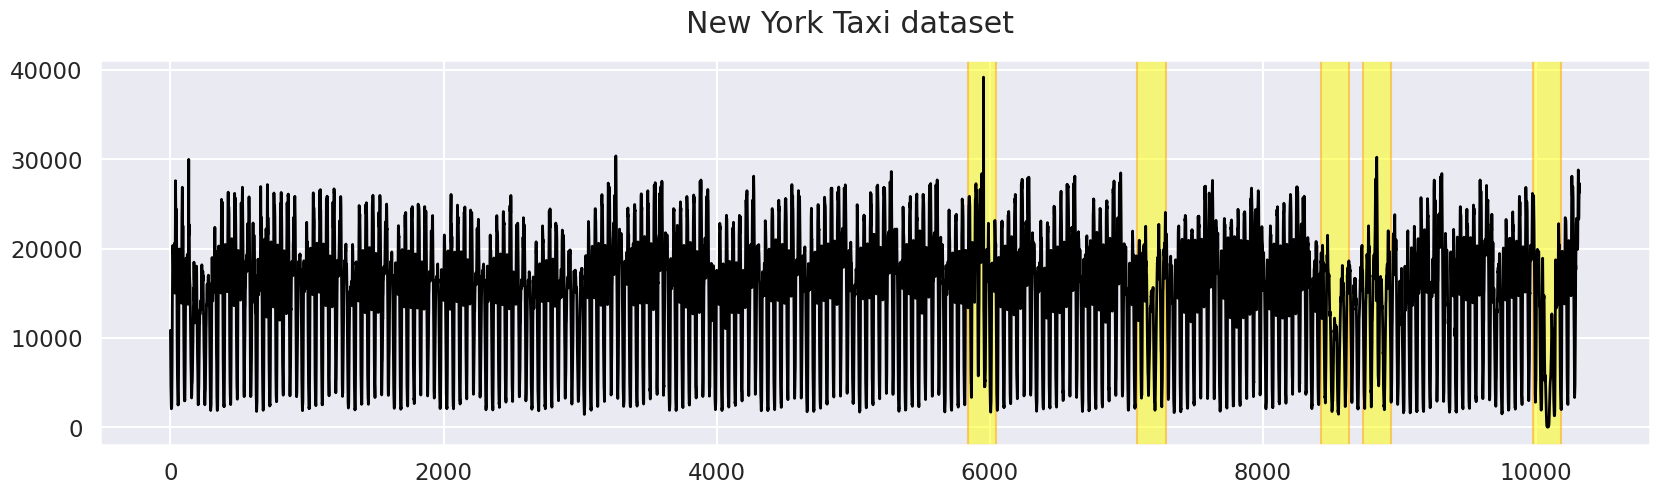

In [5]:
plot_anomaly_detection(X_nyc_taxi, y_nyc_taxi, title="New York Taxi dataset")

(<Figure size 2000x500 with 1 Axes>, array([<Axes: >], dtype=object))

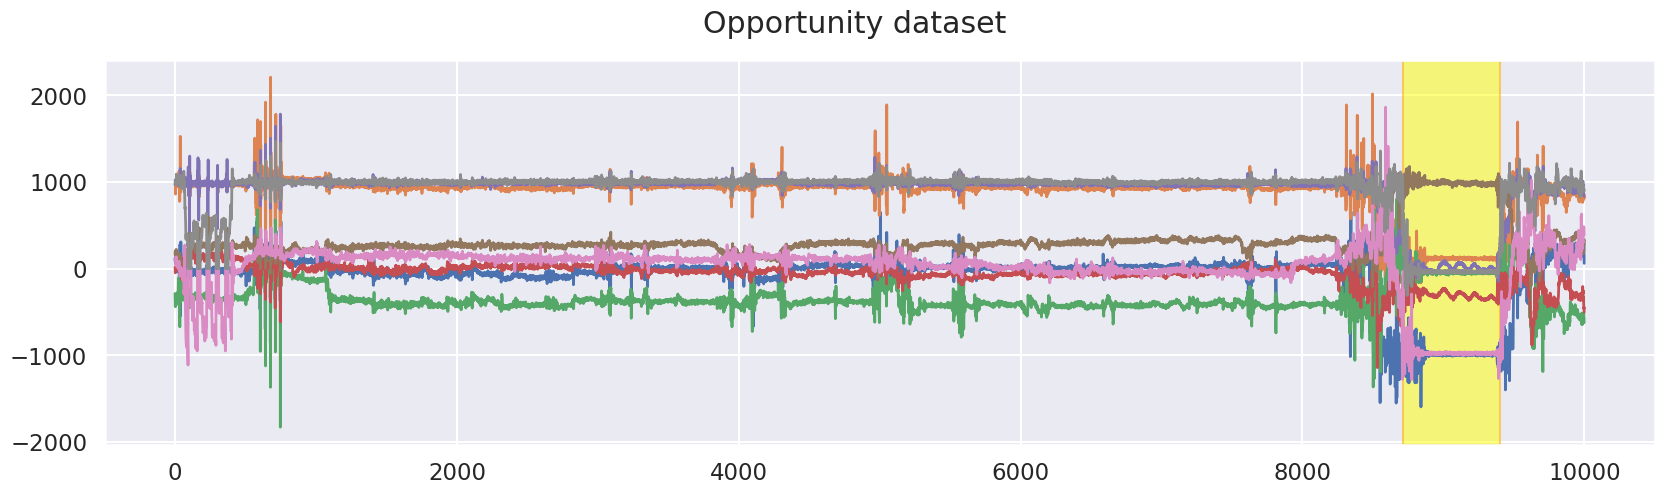

In [6]:
plot_anomaly_detection(X_opp, y_opp, title="Opportunity dataset")

## Available estimators

The anomaly detection module in `aeon` is still being developed. Currently, there are four detectors directly implemented in aeon with many more to come. However, the [`PyODAdapter`](https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.anomaly_detection.PyODAdapter.html) allows us to use all outlier detection methods of [PyOD](https://pyod.readthedocs.io/en/latest/) for time series anomaly detection.

You can find a list of all supported detectors [here](https://www.aeon-toolkit.org/en/stable/api_reference/anomaly_detection.html#detectors).
This notebook will showcase the usage of the anomaly detection module based on the following estimators:

- STOMP
- k-Means
- `PyODAdapter` with Isolation Forest
- `PyODAdapter` with AutoEncoder

`aeon` follows the `scikit-learn` interface. Anomaly detectors can be trained
on a reference time series using `fit`, and then predictions for the target
time series can be made using `predict`.
Most anomaly detection problems, however, do not come with a (labeled)
training/reference time series. We, thus, focus our example on unsupervised
anomaly detection. For the AutoEncoder, we will show a semi-supervised use
case.

## Distance-based anomaly detection

Distance-based anomaly detection methods use specialized distance metrics to compare points or subsequences of a time series with each other. The distance to all other subsequences, some nearest neighbors, or certain cluster reference points are used as the anomaly score.
A prominent representative of this method family is the matrix profile. Aeon implements the STOMP algorithm to efficiently compute the matrix profile and the K-Means algorithm for a clustering approach:

### STOMP

STOMP computes the matrix profile, which records the distance of each subsequence (of certain size) to its nearest non-self neighbor. The matrix profile can directly be interpreted as an anomaly score because a large distance to the closest neighbor might indicate an anomalous subsequence.

Range-PR-AUC score of STOMP on KDD dataset: 0.8428


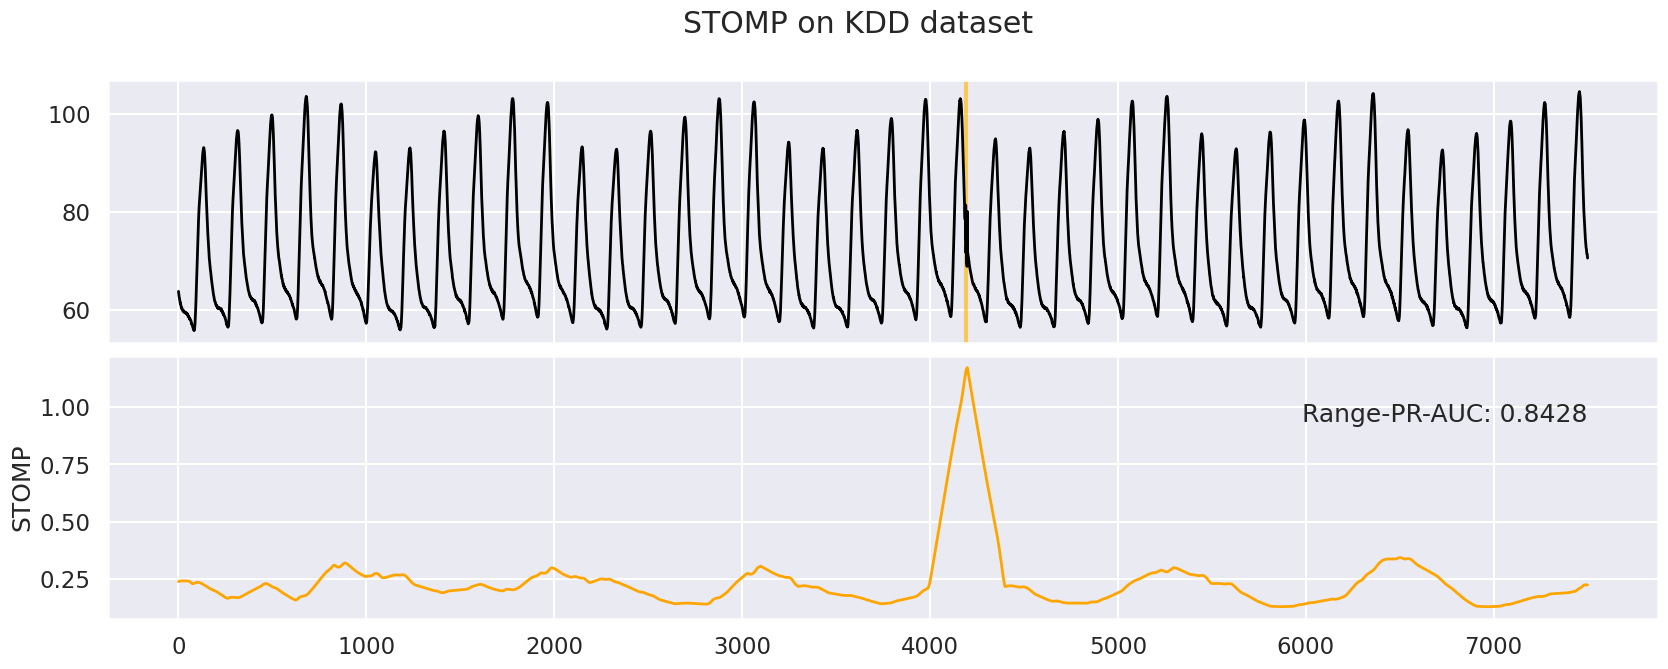

In [7]:
from aeon.performance_metrics.anomaly_detection import range_pr_auc_score
from aeon.anomaly_detection import STOMP

est = STOMP(window_size=200)
scores = est.fit_predict(X)
quality = range_pr_auc_score(y, scores)

print(f"Range-PR-AUC score of STOMP on KDD dataset: {quality:.4f}")

fig, axs = plot_anomaly_detection(X, y, scores={"STOMP": scores}, title="STOMP on KDD dataset")
_ = axs[-1].text(len(X), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

### k-Means

K-Means also uses a sliding window to extract subsequences from the time series. These subsequences are then clustered, and the distance between each subsequence and its corresponding cluster centroid (Euclidean distance) is used as the anomaly score.

Range-PR-AUC score of k-Means with w=50 on KDD dataset: 0.8535


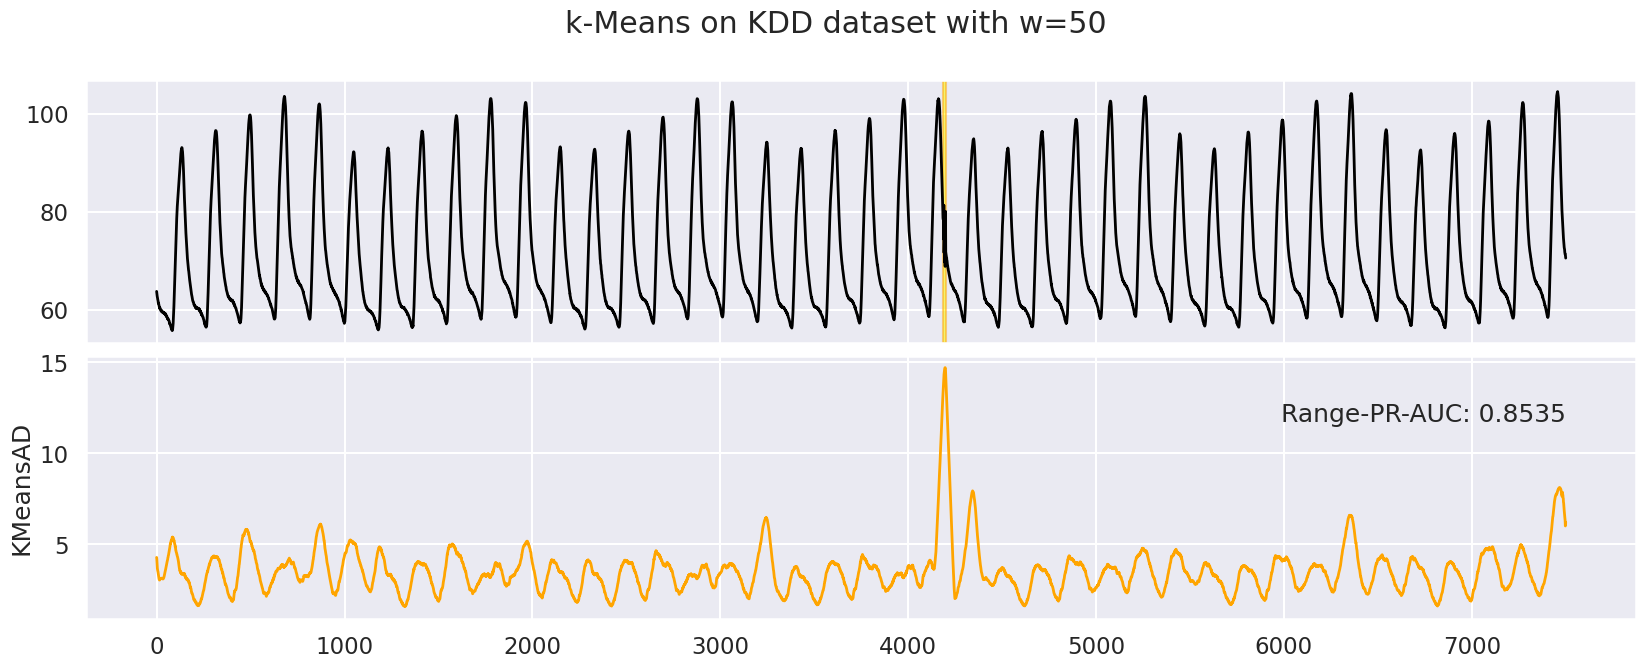

In [8]:
from aeon.anomaly_detection import KMeansAD

# window size for preprocessing the time series before applying k-Means:
w=50

est = KMeansAD(n_clusters=200, window_size=w, random_state=42)
scores = est.fit_predict(X)
quality = range_pr_auc_score(y, scores)

print(f"Range-PR-AUC score of k-Means with w={w} on KDD dataset: {quality:.4f}")

fig, axs = plot_anomaly_detection(X, y, scores={"KMeansAD": scores}, title=f"k-Means on KDD dataset with w={w}")
_ = axs[-1].text(len(X), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

While STOMP supports only univariate time series, the implementation of k-Means in aeon can process multivariate time series by encoding each two-dimensional window in a one-dimensional vector:

Range-PR-AUC score of k-Means on Opportunity dataset: 0.3861


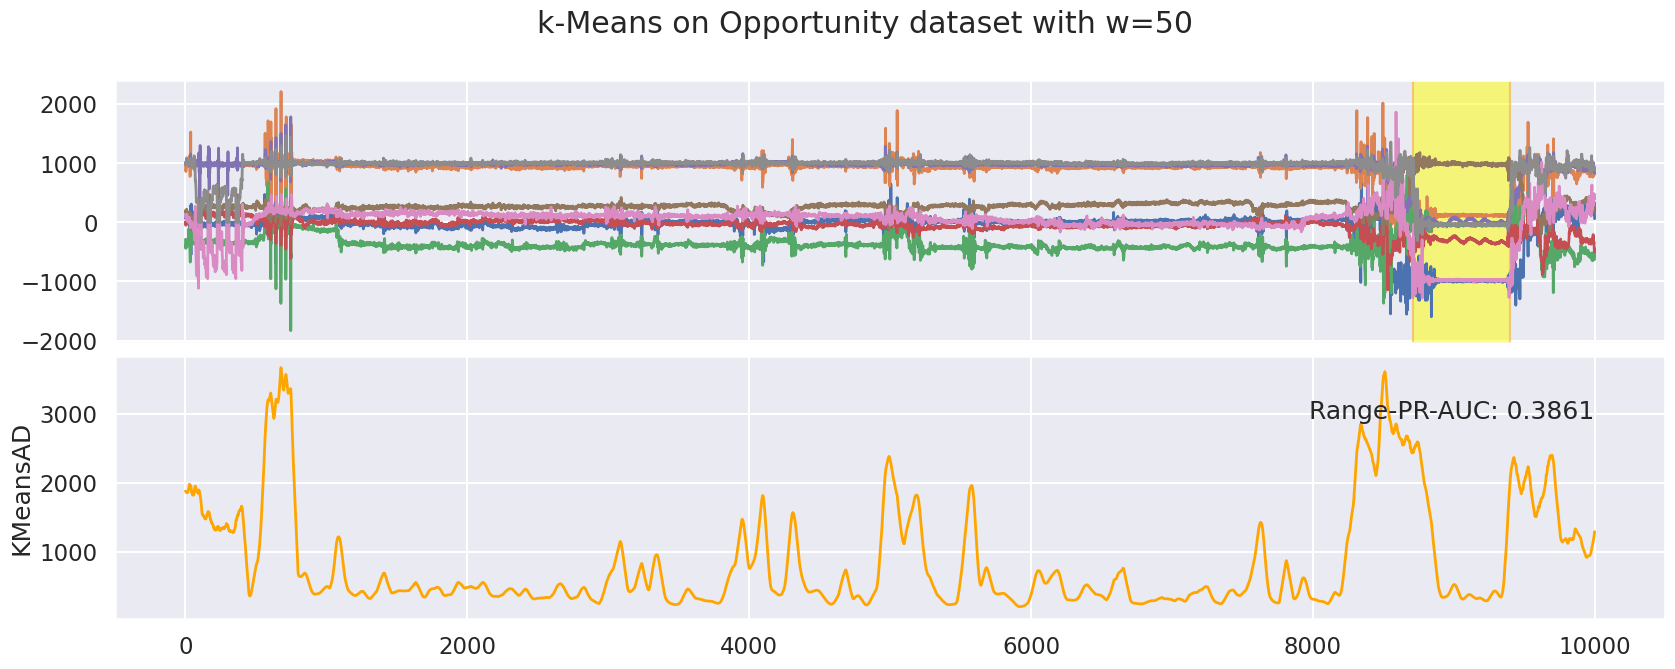

In [9]:
est = KMeansAD(n_clusters=100, window_size=50, random_state=42)
scores = est.fit_predict(X_opp, axis=0)
quality = range_pr_auc_score(y_opp, scores)

print(f"Range-PR-AUC score of k-Means on Opportunity dataset: {quality:.4f}")

fig, axs = plot_anomaly_detection(X_opp, y_opp, scores={"KMeansAD": scores}, title=f"k-Means on Opportunity dataset with w={w}")
_ = axs[-1].text(len(X_opp), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

## Tree-based anomaly detection: Isolation Forest

Tree-based methods build an ensemble of random trees that partition the points or subsequences of the time series, trying to isolate the samples in the tree. Because anomalous samples are easier to isolate, they are closer to the root of the tree. The average reciprocal path length from the roots to the sample in the trees is used as the anomaly score.

The Isolation Forest method was proposed for outlier detection in relational data (objects/instances with features), but it can also be used for time series anomaly detection. There are two approaches to this:

- point-based, where each sample in the forest corresponds to a single (potentially multivariate) point of the time series
- window-based, where each sample in the forest corresponds to a subsequence of the time series

The point-based and window-based approaches can also be used for other traditional outlier detectors to port them to time series. Thus, aeon provides the `PyODAdapter` that allows us to use any outlier detector of [PyOD](https://github.com/yzhao062/pyod) (there are many) for time series anomaly detection.

In the following example, please note that the subsequence approach is better in detecting subsequence anomalies, while the point-based approach mainly detects global point anomalies.

Range-PR-AUC score of Subsequence IF on Taxi dataset: 0.4340
Range-PR-AUC score of IF on Taxi dataset: 0.2157


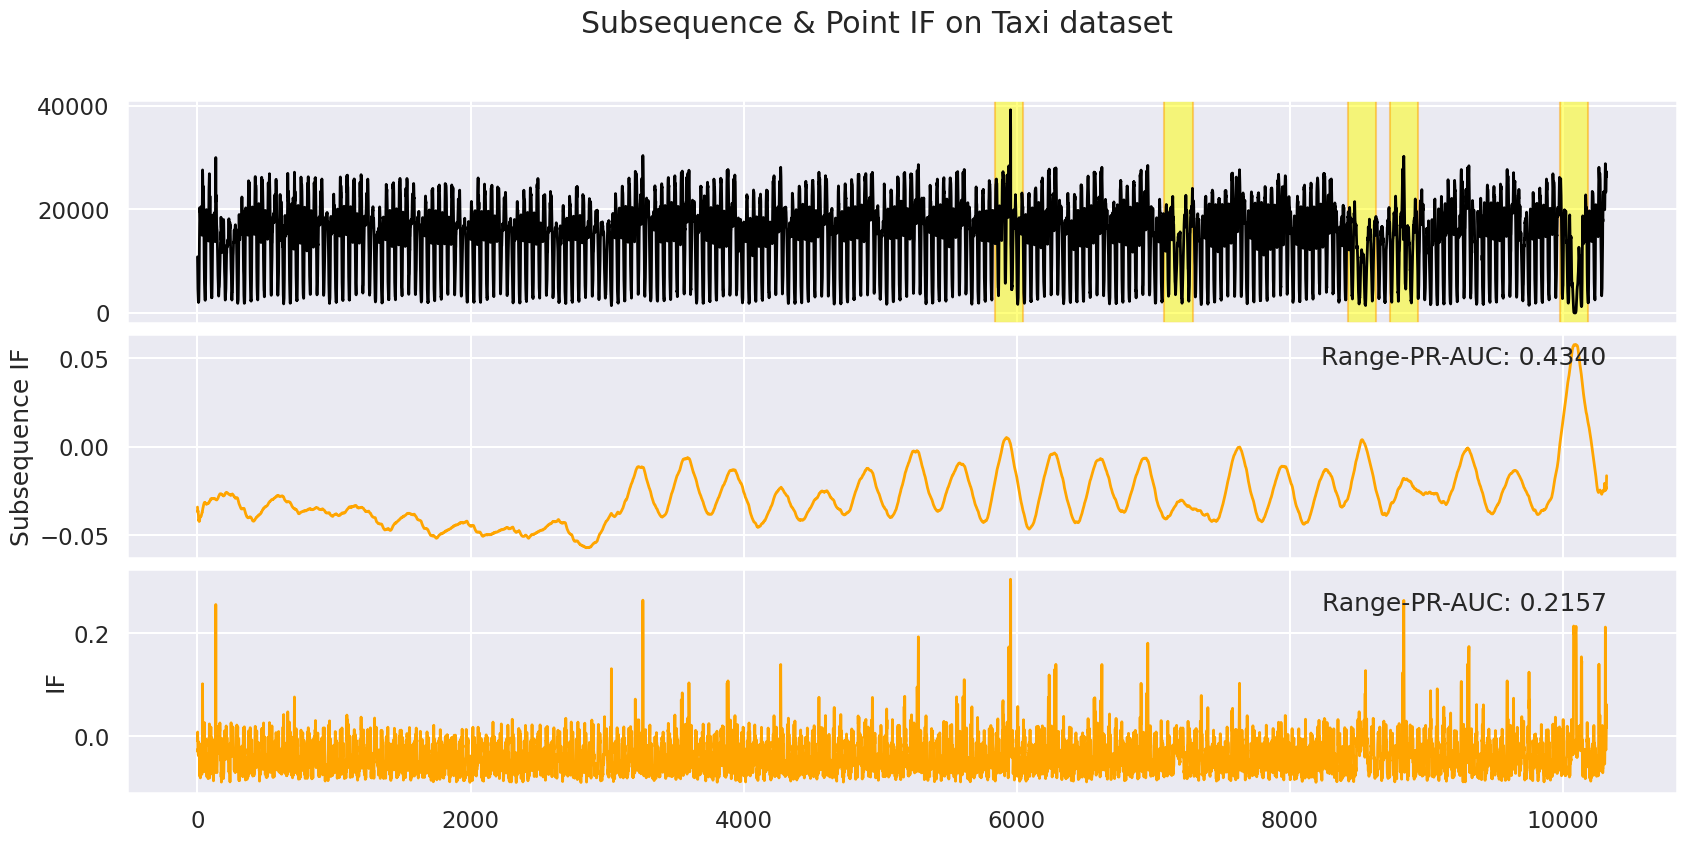

In [10]:
from aeon.anomaly_detection import PyODAdapter
from pyod.models.iforest import IForest

sub_if = PyODAdapter(IForest(), window_size=150)
sub_if_scores = sub_if.fit_predict(X_nyc_taxi)
sub_if_quality = range_pr_auc_score(y_nyc_taxi, sub_if_scores)
print(f"Range-PR-AUC score of Subsequence IF on Taxi dataset: {sub_if_quality:.4f}")

point_if = PyODAdapter(IForest(max_samples=0.25, max_features=0.25), window_size=1)
point_if_scores = point_if.fit_predict(X_nyc_taxi)
point_if_quality = range_pr_auc_score(y_nyc_taxi, point_if_scores)
print(f"Range-PR-AUC score of IF on Taxi dataset: {point_if_quality:.4f}")

fig, axs = plot_anomaly_detection(X_nyc_taxi, y_nyc_taxi, scores={
    "Subsequence IF": sub_if_scores,
    "IF": point_if_scores,
}, title=f"Subsequence & Point IF on Taxi dataset")
_ = axs[1].text(len(X_nyc_taxi), np.max(sub_if_scores)/5*4, f"Range-PR-AUC: {sub_if_quality:.4f}", ha="right")
_ = axs[2].text(len(X_nyc_taxi), np.max(point_if_scores)/5*4, f"Range-PR-AUC: {point_if_quality:.4f}", ha="right")

### Reconstruction-based anomaly detection: AutoEncoder

Reconstruction-based detectors build a model of normal behavior by first encoding subsequences in a latent space and then trying to reconstruct the subsequence again. Anomalies are harder to reconstruct from the latent space because they were not part of the training data used to build the normal model. Thus, the reconstruction error is used as an anomaly score.

This method family is inherently semi-supervised because it needs to learn/build the normal model using a time series without anomalies.

We demonstrate this family using the `AutoEncoder` model, which is a simple fully connected deep neural network (per default) four hidden layers and dropout.

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.65it/s]


Range-PR-AUC score of AutoEncoder on KDD dataset: 0.7942


Text(7501, 0.910329749584198, 'Range-PR-AUC: 0.7942')

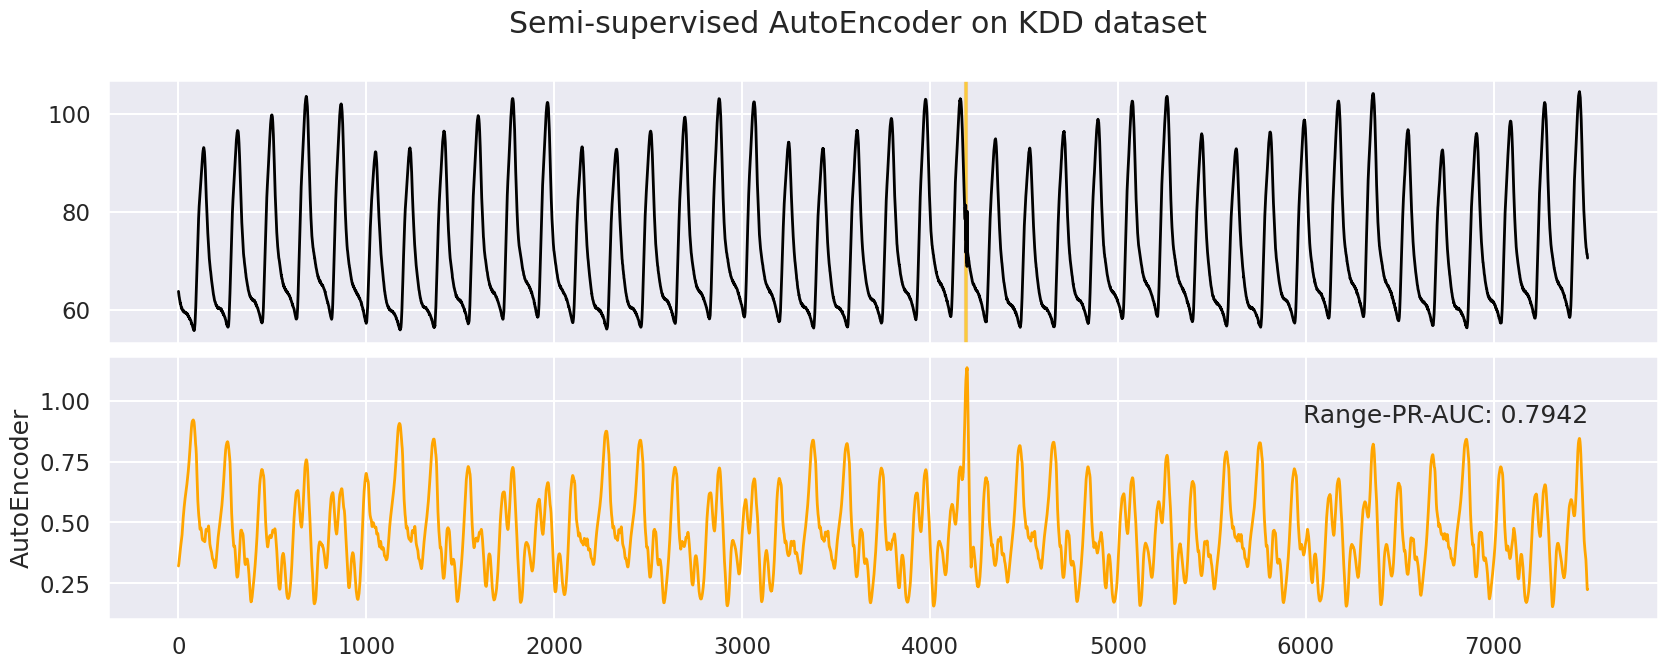

In [11]:
from aeon.anomaly_detection import PyODAdapter
from pyod.models.auto_encoder import AutoEncoder

est = PyODAdapter(AutoEncoder(epoch_num=50), window_size=20, stride=1)
# build normal model on time series without anomalies
est.fit(X_train)

# detect anomaly in target time series
scores = est.predict(X)

quality = range_pr_auc_score(y, scores)
print(f"Range-PR-AUC score of AutoEncoder on KDD dataset: {quality:.4f}")
fig, axs = plot_anomaly_detection(X, y, scores={"AutoEncoder": scores}, title=f"Semi-supervised AutoEncoder on KDD dataset")
axs[-1].text(len(X), np.max(scores)/5*4, f"Range-PR-AUC: {quality:.4f}", ha="right")

The `AutoEncoder` detector is a good example for a method that is best used in semi-supervised scenarios (with a normal reference time series as training data) because when fitted on the target time series, the `AutoEncoder` learns to reconstruct the anomalies as well:

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.95it/s]


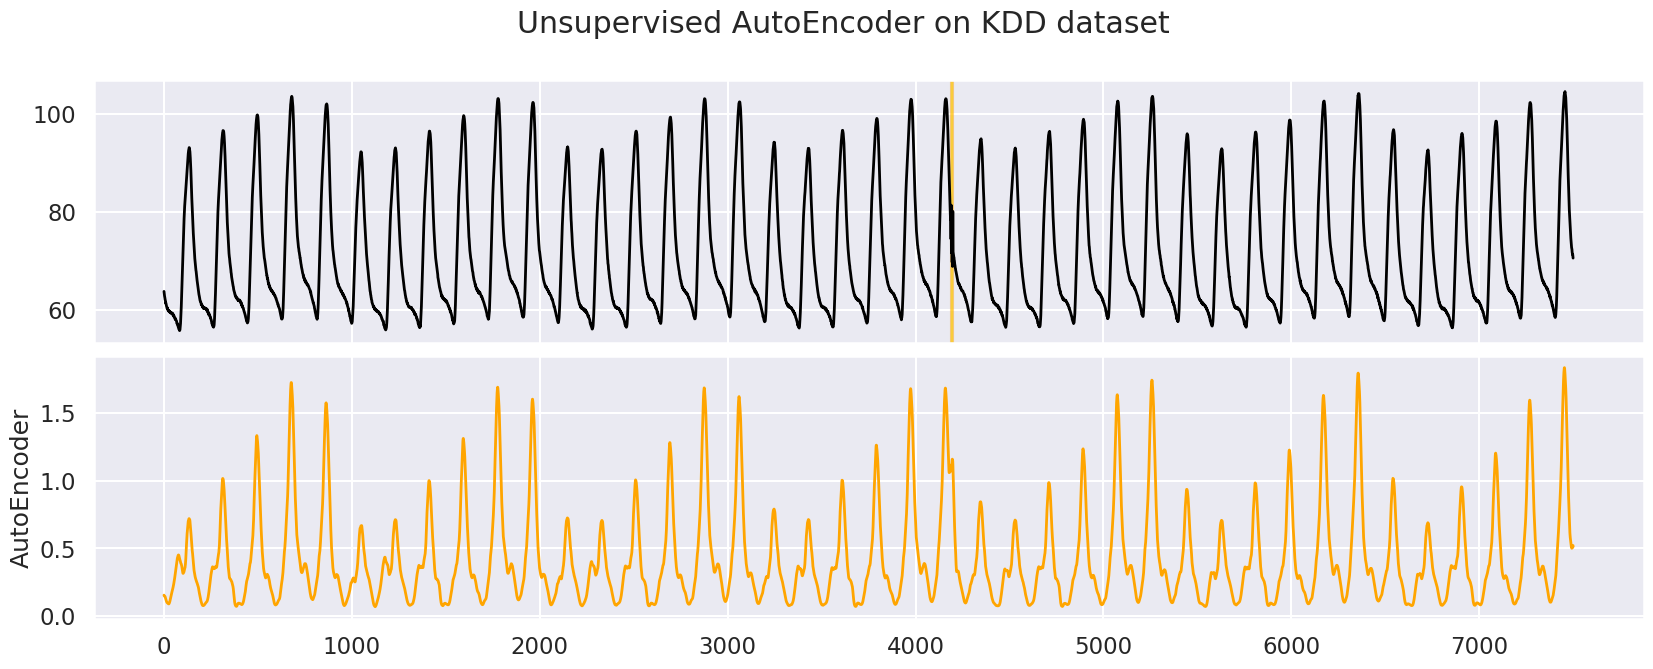

In [12]:
scores = est.fit_predict(X)
fig, axs = plot_anomaly_detection(X, y, scores={"AutoEncoder": scores}, title=f"Unsupervised AutoEncoder on KDD dataset")

## Performance comparison of anomaly detectors

The research community uses various metrics to assess the detection quality of time series anomaly detectors. Traditionally, point-based metrics were used. These metrics consider each point of the time series individually. In this way, anomaly detection is a heavily imbalanced problem. Point-wise metrics are Precision, Recall, F1-score, and the threshold-agnostic Area-under-the-curve metrics for Precision-Recall (PR-AUC) and the Receiver Operating Curve (ROC-AUC). If Precision, Recall, or F1 is used, one needs to choose a good threshold to convert the anomaly scores to binary predictions, which is a research problem in its own right! Thus, we highly advise on using a threshold-agnostic measure if the method does not provide binary output.

Furthermore, range-based metrics were introduced. These metrics consider anomalous subsequences instead of individual points, and balance mere detection and the coverage of detected anomalies.

The list of metrics is long. We refer the interested reader to the following paper:

> Sondre Sørbø and Massimiliano Ruocco. _Navigating the Metric Maze: A Taxonomy of Evaluation Metrics for Anomaly Detection in Time Series_. ArXiv 2023. https://arxiv.org/abs/2303.01272.

Aeon implements the following threshold-agnostic metrics:

- `roc_auc_score`
- `pr_auc_score`
- `rp_rr_auc_score`
- `f_score_at_k_points`
- `f_score_at_k_ranges`
- `range_roc_auc_score`
- `range_roc_vus_score`
- `range_pr_auc_score`
- `range_pr_vus_score`

We will demonstrate the usage of the `range_roc_auc_score`, `range_pr_auc_score`, and `f_score_at_k_ranges` metrics in this notebook:

In [13]:
from aeon.performance_metrics.anomaly_detection import f_score_at_k_ranges, range_roc_auc_score, range_pr_auc_score
from pyod.models.lof import LOF

# Execute the detectors on both univariate datasets
detectors = {
    "STOMP": STOMP(window_size=100),
    "K-Means": KMeansAD(n_clusters=50, window_size=100, random_state=42),
    "Sub-LOF": PyODAdapter(LOF(), window_size=100),
    "Sub-IF": PyODAdapter(IForest(), window_size=100),
    "IF": PyODAdapter(IForest(), window_size=1),
    # ! Attention ! we use the AutoEncoder unsupervised, which is not recommended
    "AE": PyODAdapter(AutoEncoder(), window_size=100)
}
datasets = {
    "KDD": X, 
    "Taxi": X_nyc_taxi
}
ground_truths = {
    "KDD": y,
    "Taxi": y_nyc_taxi
}
scores = {}
metrics = []
for d in datasets:
    scores[d] = {}
    for detector in detectors:
        est = detectors[detector]
        score = est.fit_predict(datasets[d])
        scores[d][detector] = score
        entry = {"dataset": d, "algorithm": detector}
        for m in [f_score_at_k_ranges, range_roc_auc_score, range_pr_auc_score]:
            entry[m.__name__] = m(ground_truths[d], score)
        metrics.append(entry)

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.34it/s]


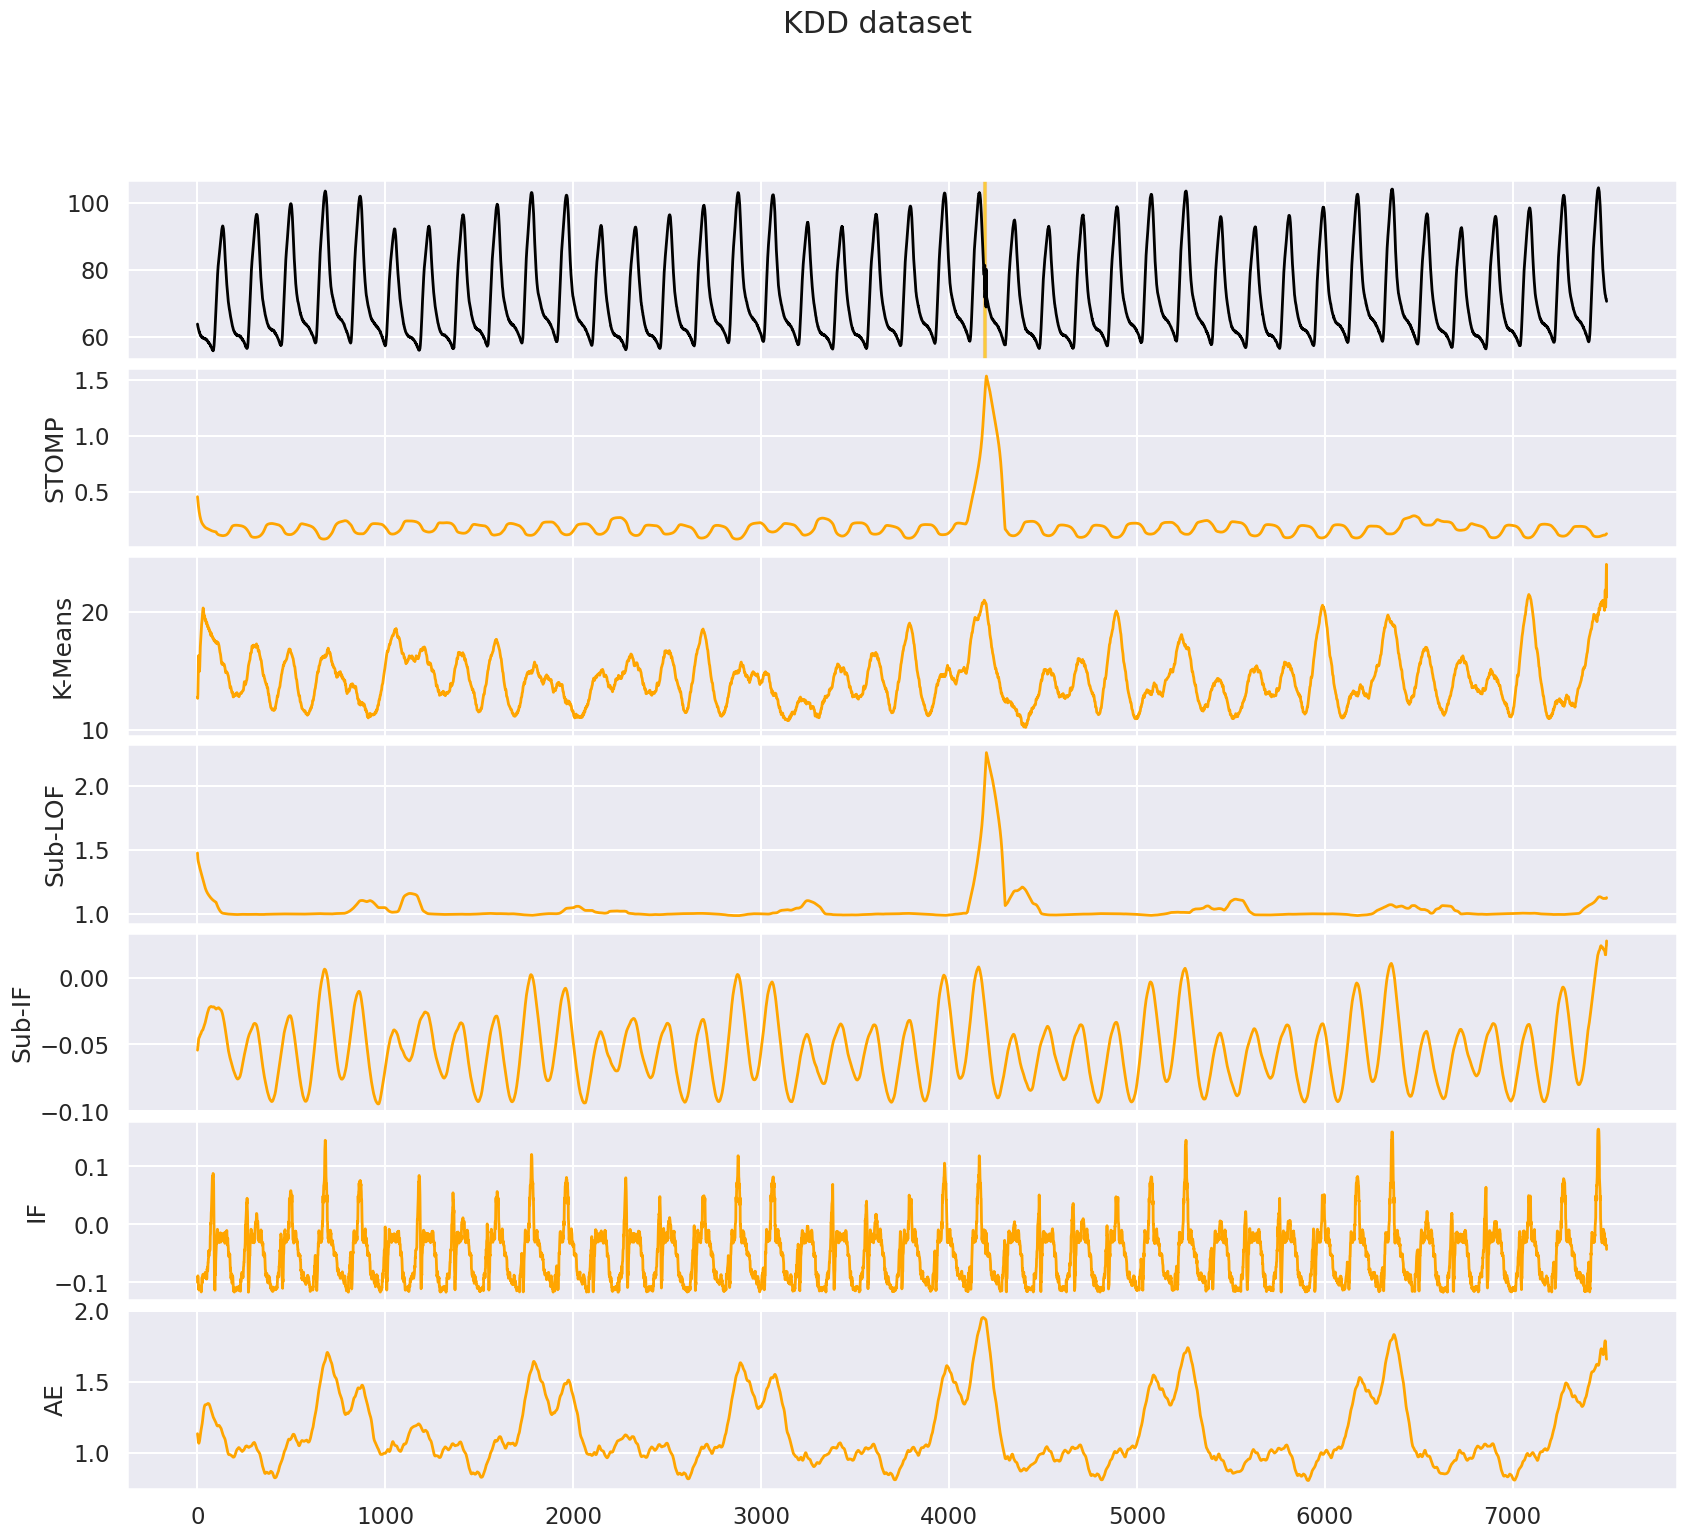

In [14]:
fig, axs = plot_anomaly_detection(X, y, scores=scores["KDD"], title="KDD dataset")

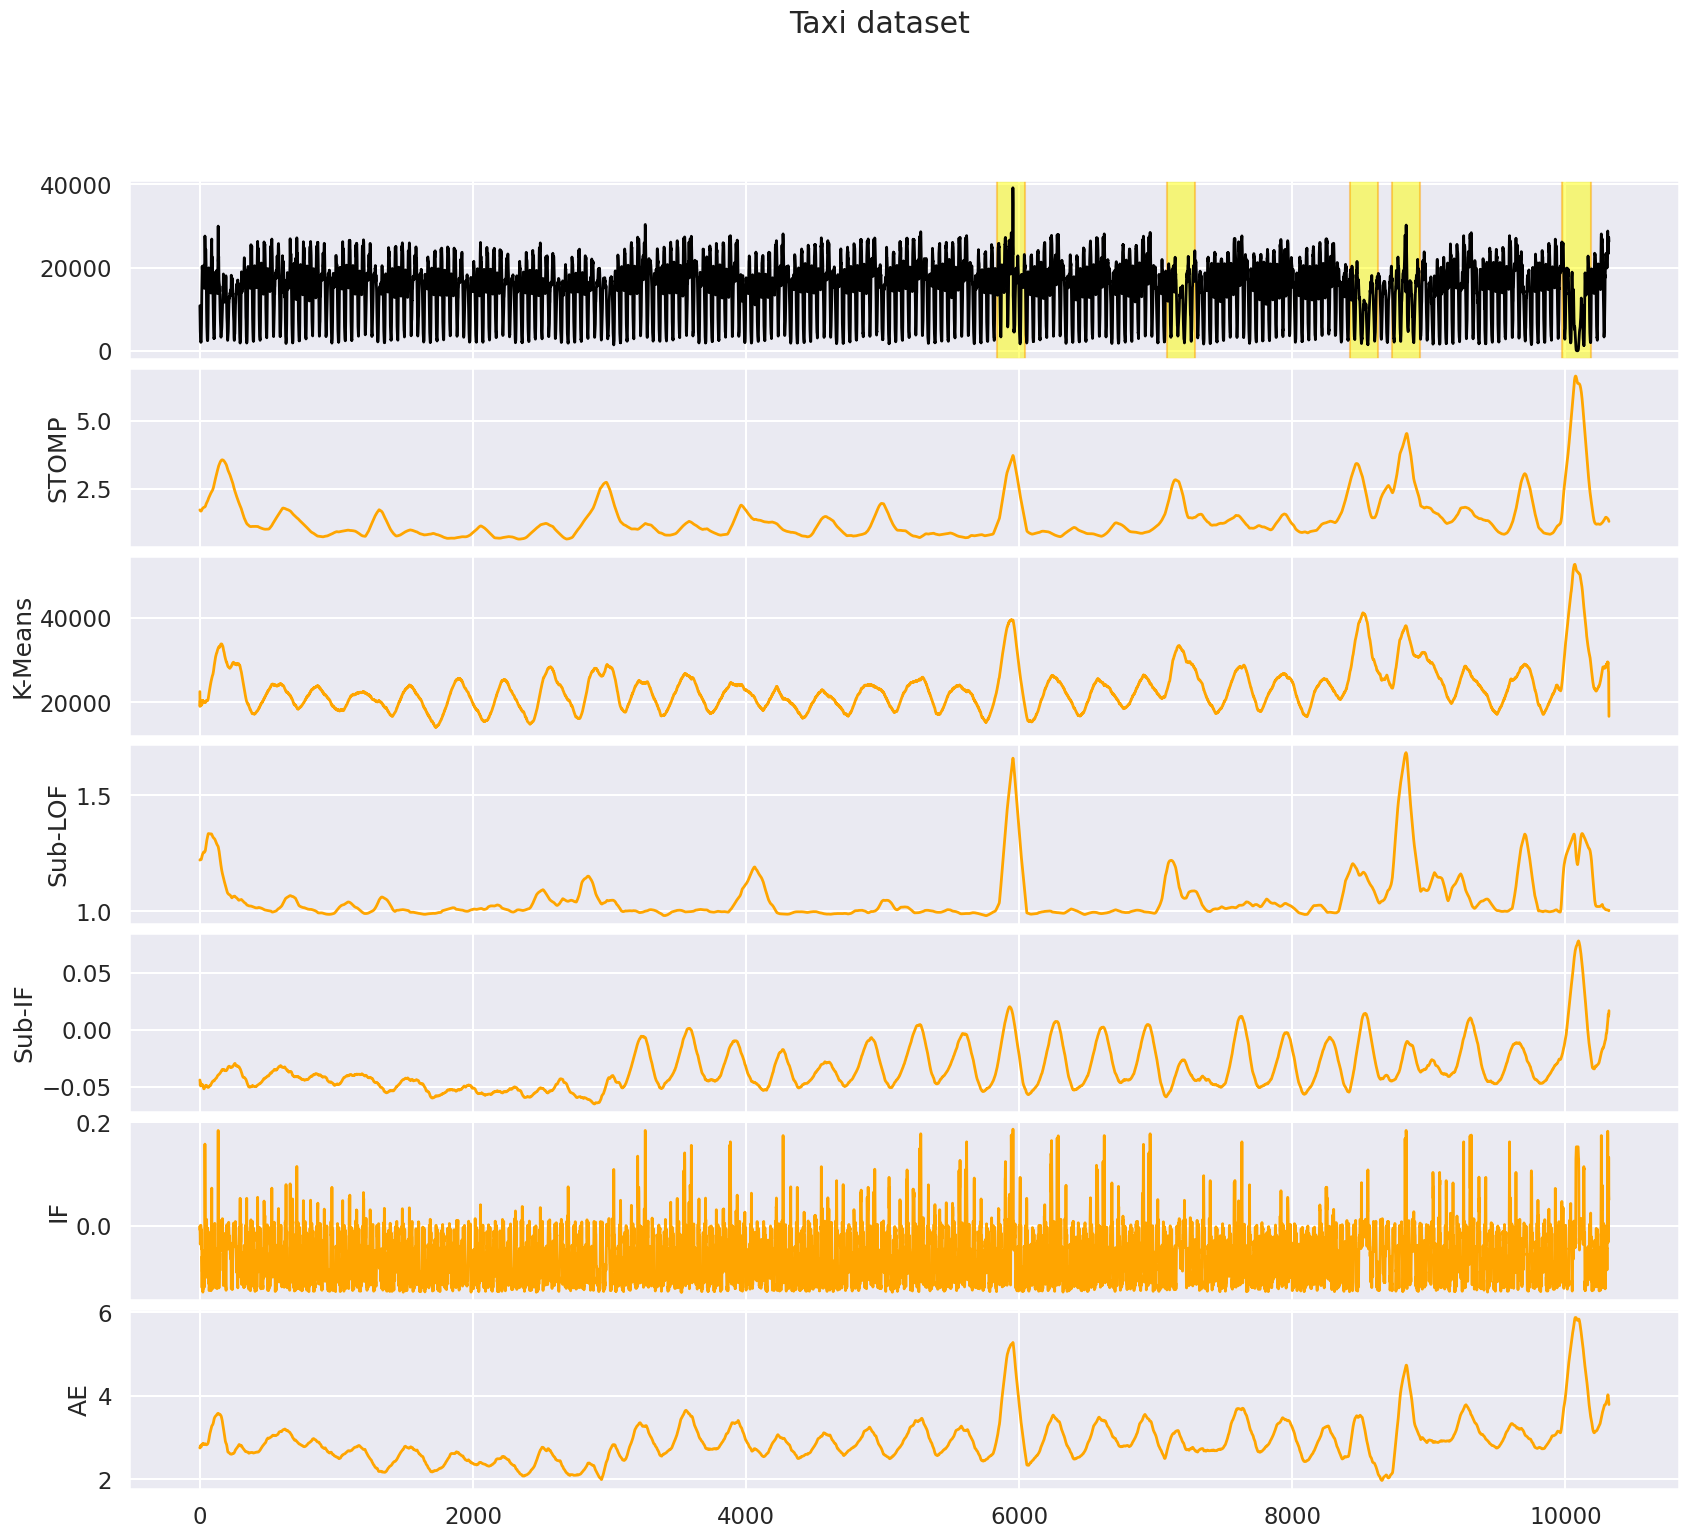

In [15]:
fig, axs = plot_anomaly_detection(X_nyc_taxi, y_nyc_taxi, scores=scores["Taxi"], title="Taxi dataset")

For our toy evaluation (with just two datasets), the performance analysis looks like the following:

,dataset,algorithm,f_score_at_k_ranges,range_roc_auc_score,range_pr_auc_score
0,Taxi,K-Means,0.750000,0.929923,0.779484
1,KDD,AE,0.000000,0.999161,0.708551
2,Taxi,STOMP,0.800000,0.941146,0.699574
3,Taxi,Sub-LOF,0.600000,0.935487,0.665478
4,KDD,STOMP,0.000000,0.998104,0.612189
5,KDD,Sub-LOF,0.000000,0.997582,0.535781
6,Taxi,AE,0.600000,0.755242,0.450414
7,Taxi,Sub-IF,0.685714,0.762233,0.366149
8,Taxi,IF,0.400000,0.653728,0.207391
9,KDD,K-Means,0.000000,0.994591,0.140757


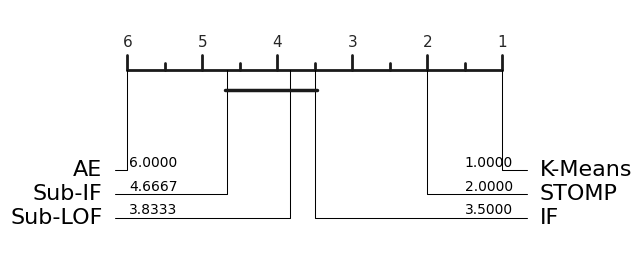

In [16]:
import pandas as pd
from aeon.visualisation import plot_critical_difference

df = (pd.DataFrame(metrics)
      .sort_values("range_pr_auc_score", ascending=False)
      .reset_index(drop=True)
)
cd = df.pivot(index="algorithm", columns="dataset")
plot_critical_difference(cd.values, cd.index)
df

For actual performance charts, please consider the following two benchmark papers:

> Sebastian Schmidl, Phillip Wenig, and Thorsten Papenbrock. _Anomaly Detection in Time Series: A Comprehensive Evaluation_. PVLDB, 15(9): 1779 - 1797, 2022. doi:[10.14778/3538598.3538602](https://doi.org/10.14778/3538598.3538602)

The results of this evaluation can also be explored at https://timeeval.github.io/evaluation-paper/.

> John Paparrizos, Yuhao Kang, Paul Boniol, Ruey S. Tsay, Themis Palpanas, and Michael J. Franklin. TSB-UAD: An End-to-End Benchmark Suite for Univariate Time-Series Anomaly Detection_. PVLDB, 15(8): 1697 - 1711, 2022. doi:[10.14778/3529337.3529354](https://doi.org/10.14778/3529337.3529354)

The code for this benchmark is at: https://github.com/TheDatumOrg/TSB-UAD